In [2]:
import pandas as pd
import numpy as np
import os
from functions_distance import *

In [3]:
path_data = '/Users/alouette/Documents/Perceptual_Space_ALS/'

## Characterize geometry of perceptual space
Euclidian distance based on 2 first dimension of PCA space 

In [ ]:
stims = ['music','face','odor']
nb_stim = 18

for stim in stims:
    files_pca = [f for f in os.listdir(path_data + 'df_pca/') if f.endswith(stim+'_PCA.csv')]

    all_dist = np.zeros((nb_pairs(nb_stim),len(files_pca)))
    all_sub = []
    for i, f in enumerate(files_pca):
        df = pd.read_csv(path_data+'df_pca/'+ f, index_col=0)
        pairs = define_pairs(df.stimulus_name)
        dist = compute_all_dist(df, pairs, name_col='stimulus_name',
                           x_col='coord.Dim.1', y_col='coord.Dim.2')
        all_dist[:,i] += dist
        all_sub.append(df.subject.values[0])

    data_df = np.concatenate((np.array(pairs),all_dist),axis=1)
    df_all = pd.DataFrame(data=data_df, columns=['p0','p1']+all_sub)
    df_all.to_csv(path_data+'Python/all_dist_stim='+stim+'.csv')

## Compare perceptual space
Compare the consistency (R) btw space across subject for each sensory modality

### Compute perceptual spaces' consistency across subjects

In [18]:
path_df = path_data+'Python/all_dist_stim={}.csv'
stims = ['music','face','odor']

space_r = []
for stim in stims:
    df = pd.read_csv(path_df.format(stim), index_col=0)
    subj = [c for c in df.columns if c not in ['p0','p1']]
    pairs_su = define_pairs(subj)
    corr = compute_all_R(df, pairs_su, meth='spearman')
    space_r.append(corr) 
space_r = np.transpose(np.vstack(space_r))

df_r_var = pd.DataFrame(space_r, columns=stims)
print(df_r_var.describe())
df_r_var.to_csv(path_data+'Python/btw_subj_consistency_allstims.csv',index=False)

             music         face         odor
count  1128.000000  1128.000000  1128.000000
mean      0.033554     0.035177     0.045371
std       0.110783     0.120131     0.114710
min      -0.244730    -0.300403    -0.288868
25%      -0.045913    -0.046265    -0.035177
50%       0.028765     0.029434     0.042509
75%       0.103690     0.114200     0.123893
max       0.394209     0.424196     0.502203


### Compare consistencies across modality (+ paired links)


ANOVA SUMMARY

Source      ddof1    ddof2      F    p-unc    ng2    eps
--------  -------  -------  -----  -------  -----  -----
stims           2     2254  3.595    0.028  0.002  0.997


POST HOC TESTS

Contrast    A      B      Paired    Parametric         T       dof  alternative      p-unc    p-corr  p-adjust      BF10    hedges
----------  -----  -----  --------  ------------  ------  --------  -------------  -------  --------  ----------  ------  --------
stims       face   music  True      True           0.335  1127.000  two-sided        0.738     1.000  bonf         0.035     0.014
stims       face   odor   True      True          -2.110  1127.000  two-sided        0.035     0.105  bonf         0.308    -0.087
stims       music  odor   True      True          -2.538  1127.000  two-sided        0.011     0.034  bonf         0.826    -0.105

       X     Y   method alternative     n         r          CI95%     p-unc  \
0  music  face  pearson   two-sided  1128  0.008373  [-0.05

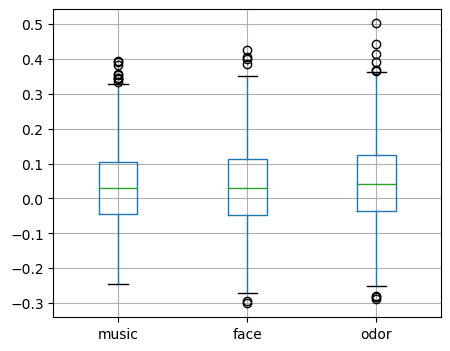

In [39]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
import pingouin as pg 

df_r_var = pd.read_csv(path_data+'Python/btw_subj_consistency_allstims.csv')

# Plot results 
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(5,4))
df_r_var.boxplot(column=stims, ax=axes)

# Compute 1-way repeated measures ANOVA
df_r_stats = df_r_var.melt()
df_r_stats.columns = ['stims','btw_su_corr']
df_r_stats['su_pairs'] = np.concatenate([np.arange(0,df_r_var.shape[0],1)]*3)
anova = pg.rm_anova(data=df_r_stats, dv='btw_su_corr', within='stims',
                    subject='su_pairs')
pg.print_table(anova, floatfmt='.3f')

# Bonf-corrected post hocs with Hedges'g effect size
posthoc = pg.pairwise_tests(data=df_r_stats, dv='btw_su_corr', within='stims',
                            subject='su_pairs', padjust='bonf')
pg.print_table(posthoc, floatfmt='.3f')

# Pairwise correlations between sensory modality
pair_r = pg.pairwise_corr(df_r_var, method='pearson')
print(pair_r)

### Compare perceptual spaces' size and dispersion

In [104]:
stims = ['music','face','odor']
cols_to_sel = ['%var_cum','pol_surf','circ_surf','avg_d']

files_pca = [f for f in os.listdir(path_data + 'df_pca/') if f.endswith('_PCA_sum.csv')]
    
all_pca = np.zeros((len(files_pca),4))
infos = np.array([])
for i,f in enumerate(files_pca):
    splits = [sp.split('_') for sp in f.split('=')]
    s_splits = np.array((splits[1][0],splits[2][0]))
    infos = np.vstack((infos,s_splits)) if np.size(infos) else np.array(s_splits)
    
    df = pd.read_csv(path_data+'df_pca/'+f, index_col=0)
    df.columns = ['cos2','%var','%var_cum','pol_surf','circ_surf','x0','y0','avg_d']
    sel = df[cols_to_sel].loc[['comp 2']].values[0]
    all_pca[i,:] += sel

data_df = np.concatenate((infos,all_pca), axis=1)
df_all = pd.DataFrame(data=data_df, columns=['subject','stim']+cols_to_sel)
df_all.to_csv(path_data+'Python/all_spaces_geometry.csv',index=False)

### Statistics and plots - spaces geometry 


ANOVA SUMMARY

Source      ddof1    ddof2      F    p-unc    ng2    eps
--------  -------  -------  -----  -------  -----  -----
stim            2       94  8.099    0.001  0.089  0.972


POST HOC TESTS

Contrast    A      B      Paired    Parametric         T     dof  alternative      p-unc    p-corr  p-adjust       BF10    hedges
----------  -----  -----  --------  ------------  ------  ------  -------------  -------  --------  ----------  -------  --------
stim        face   music  True      True          -4.226  47.000  two-sided        0.000     0.000  bonf        215.375    -0.711
stim        face   odor   True      True          -2.781  47.000  two-sided        0.008     0.023  bonf          4.736    -0.527
stim        music  odor   True      True           1.065  47.000  two-sided        0.292     0.877  bonf          0.267     0.214


ANOVA SUMMARY

Source      ddof1    ddof2      F    p-unc    ng2    eps
--------  -------  -------  -----  -------  -----  -----
stim          

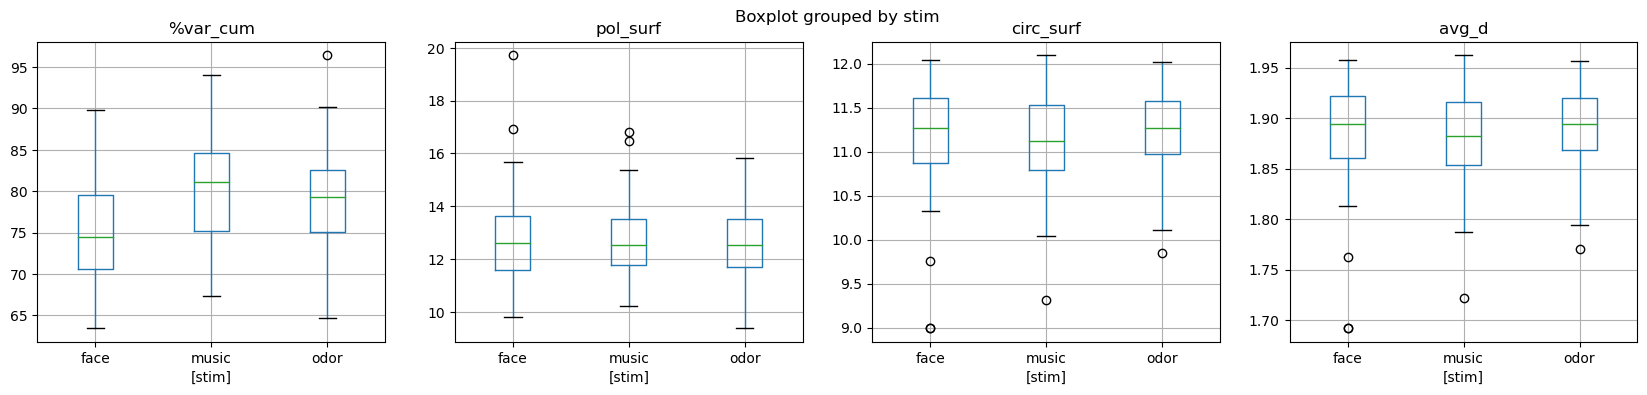

In [131]:
import pingouin as pg 

df_geo = pd.read_csv(path_data+'Python/all_spaces_geometry.csv')

# Plot results 
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20,4))
for i,c in enumerate(df_geo.columns[2:]):
    df_geo[[c,'stim']].boxplot(ax=axes[i], by='stim')
    anova = pg.rm_anova(data=df_geo, dv=c, within='stim',
                    subject='subject')
    pg.print_table(anova, floatfmt='.3f')
    
    if anova.iloc[0,4] < 0.05:
        # Bonf-corrected post hocs with Hedges'g effect size
        posthoc = pg.pairwise_tests(data=df_geo, dv=c, within='stim',
                            subject='subject', padjust='bonf')
        pg.print_table(posthoc, floatfmt='.3f')
    